In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

In [88]:
plt.rcParams.update({'figure.figsize': (20,10)})

#### Завантажуємо вибірку

In [2]:
dataset = pd.read_csv('../Data/data_for_predictions.csv')

In [81]:
dataset

,Open,Log,Log_Diff,prices_box_diff
Date,,,,
2017-01-02,998.617004,6.906371,0.035635,NaN
2017-01-03,1021.599976,6.929125,0.022754,NaN
2017-01-04,1044.400024,6.951198,0.022073,NaN
2017-01-05,1156.729980,7.053352,0.102154,NaN
2017-01-06,1014.239990,6.921895,-0.131457,NaN
...,...,...,...,...
2021-11-10,66953.335938,11.111751,-0.008868,6328.464844
2021-11-11,64978.890625,11.081818,-0.029933,2739.527344
2021-11-12,64863.980469,11.080048,-0.001770,3013.492188


In [4]:
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778 entries, 0 to 1777
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1778 non-null   datetime64[ns]
 1   Open      1778 non-null   float64       
 2   Log       1778 non-null   float64       
 3   Log_Diff  1778 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 55.7 KB


In [6]:
dataset.set_index('Date', inplace = True)

In [7]:
dataset.shape

(1778, 3)

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1778 entries, 2017-01-02 to 2021-11-14
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      1778 non-null   float64
 1   Log       1778 non-null   float64
 2   Log_Diff  1778 non-null   float64
dtypes: float64(3)
memory usage: 55.6 KB


### Будуємо графік функції і дивимось на перший погляд чи є сезонність і яка вона (адитивна чи мультиплікативна)

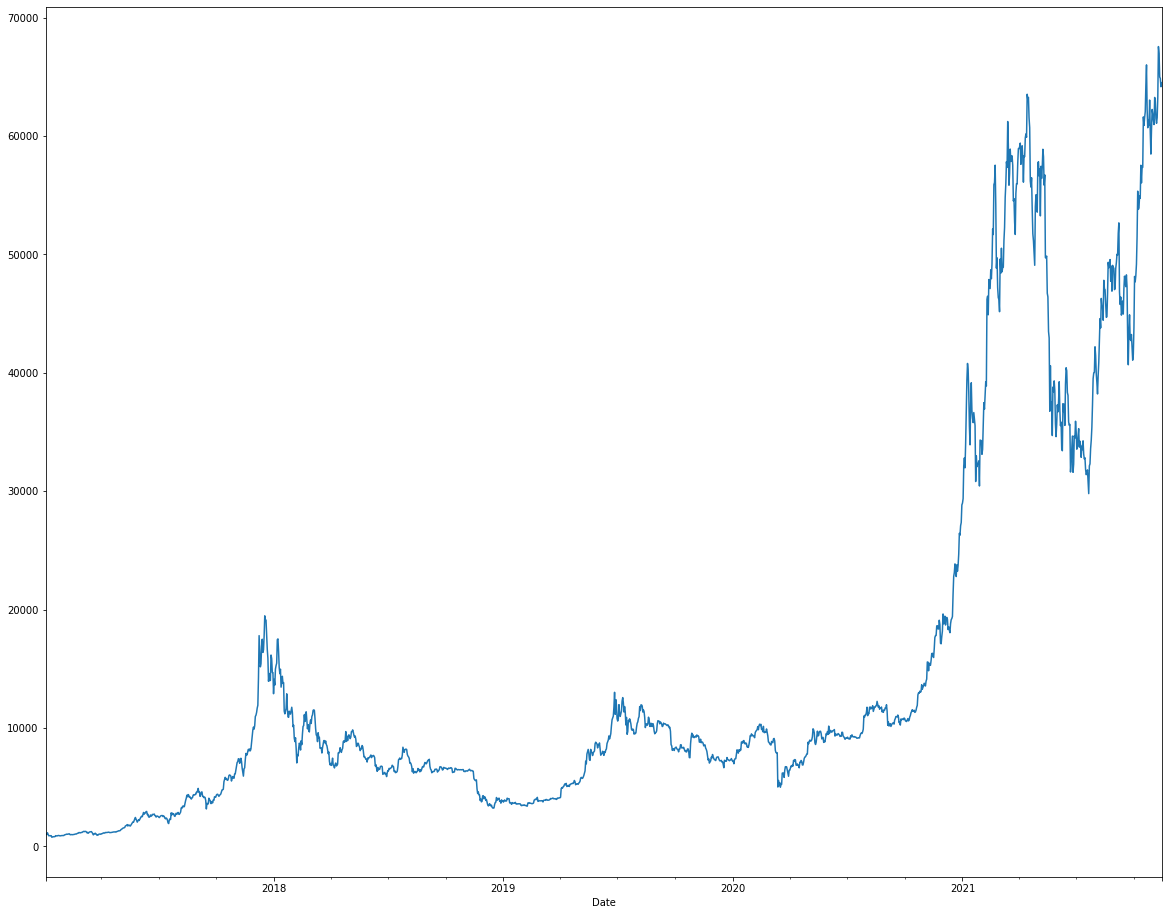

In [78]:
ax = dataset['Open'].plot()

#### 

In [68]:
p = range(0, 3, 1)
d = 1
q = range(0, 3, 1)
P = range(0, 3, 1)
D = 1
Q = range(0, 3, 1)
s = 7
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

81


In [64]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue    
        aic = model.aic
        results.append([param, aic])
        print(results, aic)
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [82]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 7, dataset['prices_box_diff'])

  0%|          | 0/81 [00:00<?, ?it/s]

[[(0, 0, 0, 0), 31651.800249120068]] 31651.800249120068
[[(0, 0, 0, 0), 31651.800249120068], [(0, 0, 0, 1), 30404.600082625257]] 30404.600082625257
[[(0, 0, 0, 0), 31651.800249120068], [(0, 0, 0, 1), 30404.600082625257], [(0, 0, 0, 2), 30403.093198776714]] 30403.093198776714
[[(0, 0, 0, 0), 31651.800249120068], [(0, 0, 0, 1), 30404.600082625257], [(0, 0, 0, 2), 30403.093198776714], [(0, 0, 1, 0), 31117.36351394126]] 31117.36351394126
[[(0, 0, 0, 0), 31651.800249120068], [(0, 0, 0, 1), 30404.600082625257], [(0, 0, 0, 2), 30403.093198776714], [(0, 0, 1, 0), 31117.36351394126], [(0, 0, 1, 1), 30403.21669656114]] 30403.21669656114
[[(0, 0, 0, 0), 31651.800249120068], [(0, 0, 0, 1), 30404.600082625257], [(0, 0, 0, 2), 30403.093198776714], [(0, 0, 1, 0), 31117.36351394126], [(0, 0, 1, 1), 30403.21669656114], [(0, 0, 1, 2), 30366.722415890967]] 30366.722415890967
[[(0, 0, 0, 0), 31651.800249120068], [(0, 0, 0, 1), 30404.600082625257], [(0, 0, 0, 2), 30403.093198776714], [(0, 0, 1, 0), 31117.3

In [83]:
result_df

,"(p,q)x(P,Q)",AIC
0,"(1, 1, 2, 1)",21291.084360
1,"(2, 2, 0, 1)",30298.779924
2,"(1, 2, 0, 1)",30322.854360
3,"(2, 1, 0, 1)",30342.028743
4,"(1, 2, 1, 2)",30344.586720
...,...,...
74,"(1, 2, 0, 0)",31646.514280
75,"(1, 1, 0, 0)",31650.669993
76,"(0, 0, 0, 0)",31651.800249
77,"(0, 1, 0, 0)",31652.511171


In [84]:
p, q, P, Q = result_df['(p,q)x(P,Q)'][0]

best_model = SARIMAX(dataset['Open'], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              Open   No. Observations:                 1778
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 7)   Log Likelihood              -14535.955
Date:                           Sat, 15 Jan 2022   AIC                          29083.910
Time:                                   17:41:08   BIC                          29116.782
Sample:                               01-02-2017   HQIC                         29096.055
                                    - 11-14-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000     33.664     -0.030      0.976     -66.980      64.980
ma.L1          1.0000     33.667      0.030

In [85]:
prediction = best_model.forecast(365)

In [86]:
prediction

2021-11-15    64388.482177
2021-11-16    64217.930553
2021-11-17    64292.802349
2021-11-18    64469.321380
2021-11-19    64434.174819
                  ...     
2022-11-10    77342.079603
2022-11-11    77340.722400
2022-11-12    77436.621749
2022-11-13    77477.516608
2022-11-14    77473.578833
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

<AxesSubplot:>

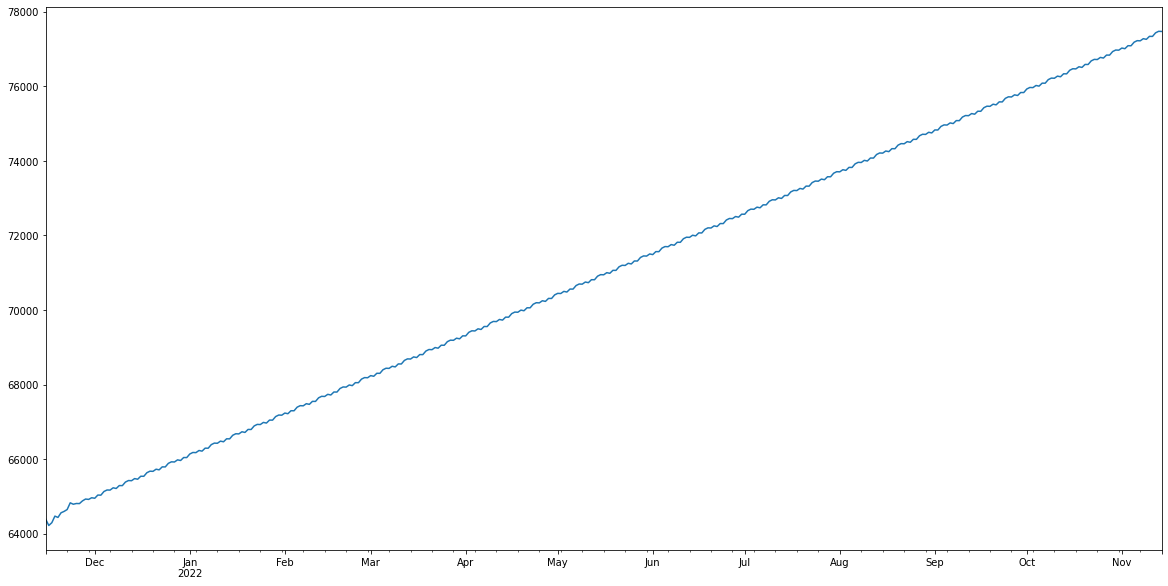

In [90]:
prediction.plot()

In [92]:
import joblib

In [93]:
joblib.dump(best_model, '../Models/model_v.0.0.0.pkl')

['../Models/model_v.0.0.0.pkl']